In [88]:
import numpy as np
from sklearn.datasets import load_iris
import sympy as sp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score


Preprocess data

In [89]:
# Load the Iris dataset
iris = load_iris()
# Access the data
data = iris.data
target = iris.target
# Shuffle the data and target arrays together
data, target = shuffle(data, target, random_state=42)
# Display some information about the dataset
print(f"Data shape: {data.shape}")
features= data.shape[1]

Data shape: (150, 4)


Fuzzy C mean


In [90]:

def initialize_membership_matrix(n_samples, n_clusters):
  return np.random.rand(n_samples, n_clusters)

def update_centroids(data, membership_matrix, g):
  n_samples, n_features = data.shape
  n_clusters = membership_matrix.shape[1]
  centroids = np.zeros((n_clusters, n_features))
  for i in range(n_clusters):
      for j in range(n_features):
          numerator = np.sum((membership_matrix[:, i]**g) * data[:, j])
          denominator = np.sum(membership_matrix[:, i]**g)
          centroids[i, j] = numerator / denominator
  return centroids

def update_membership_matrix(data, centroids, g):
  n_samples, n_features = data.shape
  n_clusters = centroids.shape[0]

  # Initialize distance matrix
  distance_matrix = np.zeros((n_samples, n_clusters))
  # Calculate the distance matrix element by element
  for i in range(n_samples):
      for j in range(n_clusters):
          # Calculate the squared distance
          squared_distance = np.sum((data[i, :] - centroids[j, :])**2)
          # Calculate the Euclidean distance and store it in the distance matrix
          distance_matrix[i, j] = np.sqrt(squared_distance)

  # Initialize membership matrix
  membership_matrix = np.zeros((n_samples, n_clusters))
  # Calculate the membership matrix
  for i in range(n_samples):
    for j in range(n_clusters):
        membership_matrix[i, j] = 1 / np.sum((distance_matrix[i, j] / distance_matrix[i, :]) ** (2 / (g - 1)))

  return membership_matrix

def fuzzy_cmeans(data, n_clusters, g, max_iter=100, tol=1e-4):
    n_samples, n_features = data.shape

    # Step 1: Initialize membership matrix randomly
    membership_matrix = initialize_membership_matrix(n_samples, n_clusters)

    for _ in range(max_iter):
        # Step 2: Update centroids
        centroids = update_centroids(data, membership_matrix, g)

        # Step 3: Update membership matrix
        new_membership_matrix = update_membership_matrix(data, centroids, g)

        # Step 4: Check for convergence
        if np.linalg.norm(new_membership_matrix - membership_matrix) < tol:  # norm is squared difference then sum all then sqrt
            break

        membership_matrix = new_membership_matrix

    return centroids, membership_matrix


Choose number of clusters

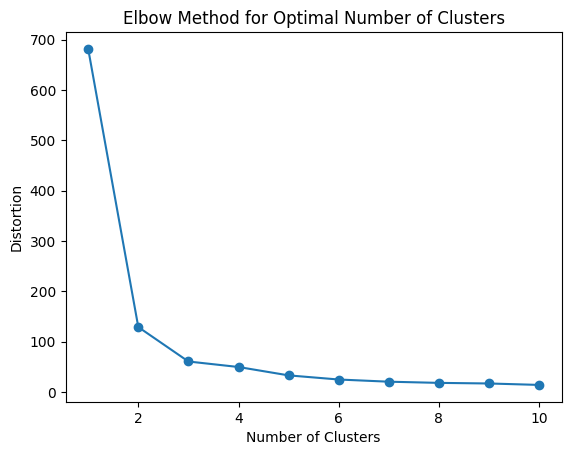

In [91]:
def calculate_elbow(data, max_clusters=10, g=2, max_iter=100, tol=1e-4):
    distortions = []

    for n_clusters in range(1, max_clusters + 1):
        centroids, membership_matrix = fuzzy_cmeans(data, n_clusters, g, max_iter, tol)
        distortion = calculate_distortion(data, centroids, membership_matrix)
        distortions.append(distortion)

    # Plot the elbow curve
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.show()

def calculate_distortion(data, centroids, membership_matrix):
  distortion = 0
  for i in range(data.shape[0]):
      for j in range(centroids.shape[0]):
        #membership * enclidean between point and cluster
        distortion += membership_matrix[i, j] ** 2 * np.sum((data[i, :] - centroids[j, :]) ** 2)
  return distortion

# Example usage
calculate_elbow(data, max_clusters=10, g=2)


Apply Fuzzy C mean on 3 clusters

In [92]:
n_clusters = 3
g = 2

centroids, membership_matrix = fuzzy_cmeans(data, n_clusters, g)

print("Centroids:")
print(centroids)
print("\nMembership Matrix:")
print(membership_matrix)

Centroids:
[[6.77499501 3.05237755 5.64676158 2.05353887]
 [5.88891896 2.76106454 4.36393206 1.39730495]
 [5.00396593 3.41408952 1.48281445 0.25354583]]

Membership Matrix:
[[8.33404203e-02 9.02725663e-01 1.39339164e-02]
 [3.03083757e-02 6.55578841e-02 9.04133740e-01]
 [7.57583008e-01 1.93239251e-01 4.91777415e-02]
 [2.61970398e-02 9.68865749e-01 4.93721092e-03]
 [4.42758691e-01 5.23635527e-01 3.36057820e-02]
 [7.93953255e-03 1.76964367e-02 9.74364031e-01]
 [9.21810129e-02 8.16177588e-01 9.16413992e-02]
 [8.55130281e-01 1.29469342e-01 1.54003776e-02]
 [1.37428812e-01 8.35427187e-01 2.71440007e-02]
 [5.03007124e-02 9.18720340e-01 3.09789480e-02]
 [7.73374364e-01 2.09862730e-01 1.67629063e-02]
 [9.17732534e-03 2.01831436e-02 9.70639531e-01]
 [1.15641794e-02 2.42517494e-02 9.64184071e-01]
 [5.34166490e-03 1.19357841e-02 9.82722551e-01]
 [6.65371564e-03 1.41575287e-02 9.79188756e-01]
 [2.97239196e-01 6.72964692e-01 2.97961124e-02]
 [9.57609763e-01 3.76362655e-02 4.75397156e-03]
 [7.0765792

PCA

In [93]:

def centerize_data(data):
    centered = data.copy()
    features = data.shape[1]

    for i in range(features):
        mean = np.mean(centered[:, i])
        centered[:, i] = centered[:, i] - mean

    return centered

def get_covariance_matrix(centered_data):
    n = centered_data.shape[0]
    cov_matrix = (1/n) * np.dot(centered_data.T, centered_data)
    return cov_matrix

def calculate_eigenvalues(cov_matrix):
    x = sp.symbols('x')
    lamda_mat = sp.eye(*cov_matrix.shape) * x
    result_matrix = lamda_mat - cov_matrix
    determinant = sp.Matrix(result_matrix).det()
    eigenvalues = sp.solve(determinant, x)
    eigenvalues = np.array(eigenvalues)
    return eigenvalues

def calculate_eigenvectors(cov_matrix):
    _, eigenvectors = np.linalg.eigh(cov_matrix)
    return eigenvectors

def PCA(data):
    features = data.shape[1]

    # Step 1: Centerize Data
    centered_data = centerize_data(data)

    # Step 2: Get Covariance Matrix
    cov_matrix = get_covariance_matrix(centered_data)
    print("Covariance Matrix:")
    print(cov_matrix)

    # Step 3: Calculate Eigenvalues
    eigenvalues = calculate_eigenvalues(cov_matrix)
    print("Eigenvalues:")
    print(eigenvalues)

    # Step 4: Calculate Eigenvectors
    eigenvectors = calculate_eigenvectors(cov_matrix)
    print("Eigenvectors:")
    print(eigenvectors)
    return centered_data, cov_matrix, eigenvalues, eigenvectors
centered_data, cov_matrix, eigenvalues, eigenvectors = PCA(data)


Covariance Matrix:
[[ 0.68112222 -0.04215111  1.26582     0.51282889]
 [-0.04215111  0.18871289 -0.32745867 -0.12082844]
 [ 1.26582    -0.32745867  3.09550267  1.286972  ]
 [ 0.51282889 -0.12082844  1.286972    0.57713289]]
Eigenvalues:
[0.0236761923536269 0.0776881033759704 0.241052942942519 4.20005342799462]
Eigenvectors:
[[ 0.31548719  0.58202985  0.65658877 -0.36138659]
 [-0.3197231  -0.59791083  0.73016143  0.08452251]
 [-0.47983899 -0.07623608 -0.17337266 -0.85667061]
 [ 0.75365743 -0.54583143 -0.07548102 -0.3582892 ]]


Choose the best number of eigen vectors

In [94]:
# Sort eigenvalues and eigenvectors in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
# Vary the number of principal components to create different Q matrices
max_components = min(len(eigenvalues), len(eigenvectors))
reconstructed_errors = []
for num_components in range(1, max_components + 1):
    top_eigenvectors = eigenvectors[:, :num_components]
    projected_data = np.dot(centered_data, top_eigenvectors)
    reconstructed_data = np.dot(projected_data, top_eigenvectors.T)
    reconstruction_error = np.mean(np.square(centered_data - reconstructed_data))
    reconstructed_errors.append(reconstruction_error)
print("Reconstructed errors :" ,reconstructed_errors)

Reconstructed errors : [0.08560430966800889, 0.02534107393239825, 0.005919048088406608, 1.7764795035856731e-31]


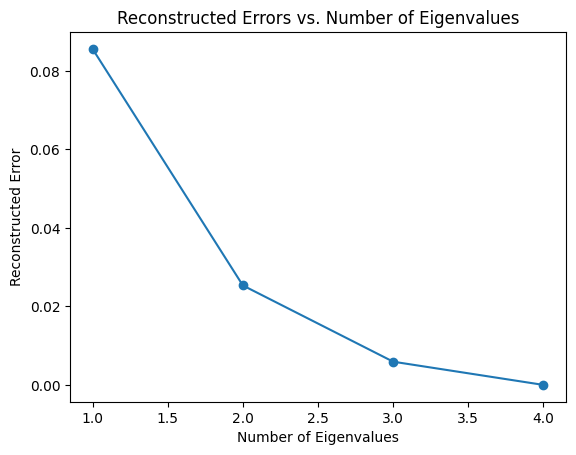

Then best number of compenets is 3
The reconstructed error significantly decreases from 1 to 2 eigenvalues.
There is still a noticeable reduction from 2 to 3 eigenvalues.
The error decreases to near-zero when using 4 eigenvalues, suggesting potential overfitting or numerical precision considerations.
using a 3-dimensional space retains most of the original information while reducing the dimensionality 


In [95]:
# Plotting the reconstructed errors
plt.plot(range(1, len(reconstructed_errors) + 1), reconstructed_errors, marker='o')
plt.title('Reconstructed Errors vs. Number of Eigenvalues')
plt.xlabel('Number of Eigenvalues')
plt.ylabel('Reconstructed Error')
plt.show()
print("Then best number of compenets is 3")
print("The reconstructed error significantly decreases from 1 to 2 eigenvalues.")
print("There is still a noticeable reduction from 2 to 3 eigenvalues.")
print("The error decreases to near-zero when using 4 eigenvalues, suggesting potential overfitting or numerical precision considerations.")
print("using a 3-dimensional space retains most of the original information while reducing the dimensionality ")


In [96]:
#Use the best Q matrix to compress the data
num_components = 3
top_eigenvectors = eigenvectors[:, :num_components]
compressed = np.dot(centered_data, top_eigenvectors)
reconstructed_data = np.dot(compressed, top_eigenvectors.T)

Fuzzy c mean after applying PCA

In [97]:
n_clusters = 3
g = 2

centroids_pca, membership_matrix_pca = fuzzy_cmeans(compressed, n_clusters, g)

print("Centroids:")
print(centroids_pca)
print("\nMembership Matrix:")
print(membership_matrix_pca)

Centroids:
[[-2.25922026  0.21661396 -0.06519816]
 [ 2.62178257  0.17544741 -0.01224838]
 [-0.62773317 -0.30813225  0.05013179]]

Membership Matrix:
[[6.15282959e-02 9.83036225e-03 9.28641342e-01]
 [3.03006080e-02 9.04070716e-01 6.56286760e-02]
 [7.57435306e-01 4.92727505e-02 1.93291943e-01]
 [2.71462638e-02 5.09415866e-03 9.67759578e-01]
 [4.43931255e-01 3.35935002e-02 5.22475245e-01]
 [5.61807089e-03 9.81777160e-01 1.26047693e-02]
 [8.90645088e-02 8.84849867e-02 8.22450504e-01]
 [9.29046187e-01 6.86076709e-03 6.40930457e-02]
 [1.17225090e-01 2.27876856e-02 8.59987225e-01]
 [4.89428560e-02 3.00896808e-02 9.20967463e-01]
 [7.76410326e-01 1.64085961e-02 2.07181078e-01]
 [9.18649528e-03 9.70581040e-01 2.02324644e-02]
 [1.03722287e-02 9.67787747e-01 2.18400242e-02]
 [5.22773953e-03 9.83077160e-01 1.16951003e-02]
 [6.47598420e-03 9.79734085e-01 1.37899306e-02]
 [3.01093049e-01 2.97943188e-02 6.69112633e-01]
 [9.57956829e-01 4.73237499e-03 3.73107956e-02]
 [7.01369438e-02 5.09702296e-02 8.7

Comapring between Fuzzy C mean before and after PCA

In [100]:
#S(i)= b(i)−a(i) / max{a(i),b(i)}
#a(i) is the average distance from the i-th data point to other data points in the same cluster. It measures cohesion.
#b(i) is the smallest average distance from the i-th data point to data points in a different cluster, minimized over clusters.It measures separation.
def calculate_silhouette_score(data, centroids, membership_matrix):
    fuzzy_labels = np.argmax(membership_matrix, axis=1)
    silhouette_avg = silhouette_score(data, fuzzy_labels)
    return silhouette_avg

silhouette_score1 = calculate_silhouette_score(data, centroids, membership_matrix)
print("Silhouette Score:", silhouette_score1)
silhouette_score2 = calculate_silhouette_score(compressed, centroids_pca, membership_matrix_pca)
print("Silhouette Score after PCA:", silhouette_score2)
print("Reducing noise after using PCA in the data lead to more meaningful and stable clusters when using Fuzzy C mean")


Silhouette Score: 0.549517512647162
Silhouette Score after PCA: 0.5594110533154549
Reducing noise after using PCA in the data lead to more meaningful and stable clusters when using Fuzzy C mean
